Creating new data for Mnist datasets and then Celebrity face is the objective of this notebook. This is also a tutorial on GAN which is more and more use for generative models.

## 1. GAN description ##

I will not too much describe it here as there are many really good websites for, all based on 2014 paper.

Basically two neural networks are competiting: a generator creates a picture, and the discriminator is trying to detect it as fake or not. We are injecting in the discrimator real picture et generated picture. After a while, generator starts generating pictures close to original dataset.

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "./gan.png",width=700, height=450)

As this my first contact with GAN, Ì will not try to produce exotic pictures, but will only use the boring Mnist dataset at first time  and apply general principles of GAN

## 2. Do it! ##

Here are the general steps I understood : 
    1. Generate few pictures with generator. This is gonna be pure random at first
    2. Get the generated pictures and add same numbers from training set. From the created batch of picture, train the generator to discern fake from real picture.
    3. After few steps of training, Discrimator is fixed and we create new picture in the generator, and we submit them to the discriminator. We optimize then the generator to make its pictures as real as possible.
    4. Repeat last 3 steps, until created pictures are good quality (i.e state of equilibrium where Generator produces picture that discriminator can not discern from real picture, while discriminator one time over two find a fake picture).

Before building the model, few interesting words from different interesting github repos and DCGAN paper:

* Batch normalization is a must in both networks.
* Fully hidden connected layers are not a good idea.
* Avoid pooling, simply stride your convolutions!
* Use ReLU activation in generator for all layers except for the output, which uses tanh. 
* Use LeakyReLU activation in the discriminator for all layers.



Minimax theorem that started the game theory states that for two players in a zero-sum game the minimax solution is the same as the Nash equilibrium.

In simpler terms, when two players (D and G) are competing against each other (zero-sum game), and both play optimally assuming that their opponent is optimally (minimax strategy), the outcome is predetermined and none of the players can change it (Nash equilibrium).
So, for our networks, it means that if we train them long enough, the Generator will learn how to sample from true “distribution,” meaning that it will start generating real life-like images, and the Discriminator will not be able to tell fake ones from genuine ones.

### 2.1 Generator ###

Generator is basically a "de"-convnet network that is outputting a picture with same dimensions from the dataset. So let's first import the mnist data.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torchvision.transforms as transforms
import torchvision
import torch.optim as optim
import numpy as np
from torch.distributions import uniform
from torch.autograd.variable import Variable


batch_size = 32
trans = transforms.Compose([transforms.Pad(2),transforms.ToTensor(),transforms.Normalize(mean=(0.5,), std=(0.5,))])




trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True,transform=trans)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


In [3]:
print(len(trainloader))

1875


We imported 15000 batches of 4 pictures.(i.e total is 60k pictures).

So we have the data, what architecture for the Generator? For about a year after the first paper, training GANs seems difficult. In 2016 Radford et al. published the paper titled “Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks” describing the model that subsequently became famous as DCGAN. In the paper, the DCGAN architecture looks like this:

In [4]:
Image(url= "./gen_architecture.png",width=700, height=450)

MNIST dataset is composed of monochrome 28x28 pixel images, so the desired shape for our input layer is [batch_size, 28, 28, 1]. This will flatten the picture in a 1D array.

Ok, so my understanding: The generated vector z has real values from -1 to 1 and follows the Gaussian distribution then :
1. Input layer. Regarding z (100,1) : We should reshape it, but seem sybilin to me. (batch_size, 100,1,1) ? 
2. First step: Project and reshape: convert our input layer to 4x4x1024.
3. 1st "deconvnet layer":the inverse of convolution, called transposed convolution, 512 filters of shape 5,5, stride=2  then relu activation. To calculate output shape of deconv layer: With padding=Same: H = H1 x stride if padding=Valid
H = (H1-1) x stride + HF (H = output size, H1 = input size, HF = height of filter)
4. 2nd "deconvnet layer: 256 filters 5x5
5. 3rd deconvnet layer: 128 filters 5,5
6. 4th deconvnet layer: 1 filters 5,5 # woulb 3 filters for RGB picture

As the output we want a 28x28 pictures. Meaning we have to change stride compares to original papers. If we keep using stride of 2, we will end up with 64x64 pictures. What we could try at first is just using a stride of 1 on first layer, in order to output 32x32 picture which is close to 28x28.

From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.2. The weights_init function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. This function is applied to the models immediately after initialization.

In [5]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

 (Remember : Order in Pytorch shape is (N,Cin,H,W) and output (N,Cout,Hout,Wout) )

In [6]:
nz= 100 #nz - length of latent vector
filter_size=[1024,512,256,128,1]

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu # number of GPUs available. If this is 0, code will run in CPU mode. If this number is greater than 0 it will run on that number of GPUs
        self.Layer1 = nn.Sequential(
            # input is Z, going into a fully connected layer
            torch.nn.Linear(in_features=nz,out_features=filter_size[0]*4*4))
        
        self.main = nn.Sequential(
            nn.BatchNorm2d(num_features=filter_size[0]),
            nn.ReLU(True), #out -1,1,1,16384
            
            # 1st T_convolution layer
            nn.ConvTranspose2d(in_channels=filter_size[0], out_channels=filter_size[1], kernel_size=5, stride=1, padding=2, bias = False),
            # The output of convTranspose2d is o = (i -1)*s - 2*p + f + output_padding => (4-1)*1 - 2*2 + 5 +0 = 4 (p=f-1/2)
            nn.BatchNorm2d(filter_size[1]),
            nn.ReLU(True), #out is -1,512,4,4
            
            
            #2nd T_convolution layer
            nn.ConvTranspose2d(in_channels=filter_size[1], out_channels=filter_size[2], kernel_size=5, stride=2, padding=2, bias = False,output_padding=1),
            nn.BatchNorm2d(filter_size[2]),
            nn.ReLU(True), #out is -1,256,8,8
            
            #3rd T_convolution layer
            nn.ConvTranspose2d(in_channels=filter_size[2], out_channels=filter_size[3], kernel_size=5, stride=2, padding=2, bias = False,output_padding=1),
            nn.BatchNorm2d(filter_size[3]),
            nn.ReLU(True), #out is -1,128,16,16
            
            #4th T_connvolution layer
            nn.ConvTranspose2d(in_channels=filter_size[3], out_channels=filter_size[4], kernel_size=5, stride=2, padding=2, bias = False,output_padding=1),
            # out is -1,1,32,32
            
            nn.Tanh()
        )

    def forward(self, input):
        out_L1 = self.Layer1(input) #out_L1 is -1,1,1,16384
        #resize to 4,4,1024
        out_L1 = out_L1.view(out_L1.shape[0],1024,4,4)

        return self.main(out_L1)
    
net = Generator(ngpu=0)

summary(net, (1,1,100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1          [-1, 1, 1, 16384]       1,654,784
       BatchNorm2d-2           [-1, 1024, 4, 4]           2,048
              ReLU-3           [-1, 1024, 4, 4]               0
   ConvTranspose2d-4            [-1, 512, 4, 4]      13,107,200
       BatchNorm2d-5            [-1, 512, 4, 4]           1,024
              ReLU-6            [-1, 512, 4, 4]               0
   ConvTranspose2d-7            [-1, 256, 8, 8]       3,276,800
       BatchNorm2d-8            [-1, 256, 8, 8]             512
              ReLU-9            [-1, 256, 8, 8]               0
  ConvTranspose2d-10          [-1, 128, 16, 16]         819,200
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
  ConvTranspose2d-13            [-1, 1, 32, 32]           3,200
             Tanh-14            [-1, 1,

(3, 1, 32, 32)


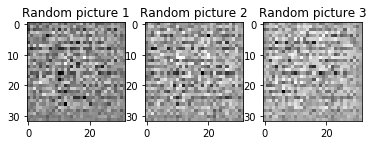

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

BATCH_SIZE = 3

Z = np.random.uniform(-1, 1, (BATCH_SIZE, 100))

Z = torch.from_numpy(Z)
Z= Z.float()
gen = Generator(0)
criterion = torch.nn.BCELoss() #binary cross entrpy
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


generated_images = gen(Z)

generated_images = generated_images.detach().numpy()

print(generated_images.shape)
plt.subplot(1, 3, 1)
plt.imshow(generated_images[0].reshape(32, 32), cmap=plt.cm.Greys)
plt.title('Random picture 1')

plt.subplot(1, 3, 2)
plt.imshow(generated_images[1].reshape(32, 32), cmap=plt.cm.Greys)
plt.title('Random picture 2')
    
plt.subplot(1, 3, 3)
plt.imshow(generated_images[2].reshape(32, 32), cmap=plt.cm.Greys)
plt.title('Random picture 3')

plt.show()

Cool, now we have a random picture generator, taking a [batch_size,100] array as input. There is a nice article about upsampling a picture, nice to read: https://towardsdatascience.com/up-sampling-with-transposed-convolution-9ae4f2df52d0

### 2.2 Discriminator ###

Basically, this is the opposite of our generator. From a 32x32 picture, we will use the convnet to output a number between 0 and 1. 

In [8]:
Image(url= "./discriminator.png",width=700, height=450)

As a reminder, the ouput size of a convolutional layer is $\frac{n+2p-f}{s}+1 $ (n= input shape, p = padding, s = stride, f= filter size). 
Padding shape is:
* "Valid" : n-f+1
* "Same" : $p=\frac{f-1}{2}$ ; $\frac{n + 2p -f}{2} +1$

There is no common rules regarding, the filter size, just a 2^n size. If I keep same kernel size as the generator, I will end up with 2x2x1024 as output of the last conv layer. This is maybe not good, but let's try.

In [9]:
filter_size_discri=[128,256,512,1024]
picture_nb_chanels = 1
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu # number of GPUs available. If this is 0, code will run in CPU mode. If this number is greater than 0 it will run on that number of GPUs
        self.main = nn.Sequential(
        
        # 1st convolution layer
        nn.Conv2d(in_channels=picture_nb_chanels, out_channels=filter_size_discri[0],kernel_size=5,stride =2,padding = 2),  
        #out: (n+2p-f)/2 +1 => (32 +2*2 -5) /2 +1 = 31/2 +1 = 16.5  =16 (take the round)
        #nn.BatchNorm2d(filter_size_discri[0]),
        nn.LeakyReLU(), #out is -1,128,16,16    
    
        # 2nd convolution layer
        nn.Conv2d(in_channels=filter_size_discri[0], out_channels=filter_size_discri[1],kernel_size=5,stride =2,padding = 2),  
        nn.BatchNorm2d(filter_size_discri[1]),
        nn.LeakyReLU(), #out is -1,256,8,8
            
            
        # 3rd convolution layer
        nn.Conv2d(in_channels=filter_size_discri[1], out_channels=filter_size_discri[2],kernel_size=5,stride =2,padding = 2),  
        nn.BatchNorm2d(filter_size_discri[2]),
        nn.LeakyReLU(), #out is -1,512,4,4
            
            
        # 4th convolution layer
        nn.Conv2d(in_channels=filter_size_discri[2], out_channels=filter_size_discri[3],kernel_size=5,stride =2,padding = 2),  
        nn.BatchNorm2d(filter_size_discri[3]),
        nn.LeakyReLU(), #out is -1,1024,2,2
            
            
        # 5th convolution layer
        nn.Conv2d(in_channels=filter_size_discri[3], out_channels=1,kernel_size=5,stride =2,padding = 2), 
        nn.Sigmoid()
        )
        
    def forward(self, input):
        return self.main(input)
        
        
dis = Discriminator(ngpu=0)

summary(dis, (1,32,32),device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 16, 16]           3,328
         LeakyReLU-2          [-1, 128, 16, 16]               0
            Conv2d-3            [-1, 256, 8, 8]         819,456
       BatchNorm2d-4            [-1, 256, 8, 8]             512
         LeakyReLU-5            [-1, 256, 8, 8]               0
            Conv2d-6            [-1, 512, 4, 4]       3,277,312
       BatchNorm2d-7            [-1, 512, 4, 4]           1,024
         LeakyReLU-8            [-1, 512, 4, 4]               0
            Conv2d-9           [-1, 1024, 2, 2]      13,108,224
      BatchNorm2d-10           [-1, 1024, 2, 2]           2,048
        LeakyReLU-11           [-1, 1024, 2, 2]               0
           Conv2d-12              [-1, 1, 1, 1]          25,601
          Sigmoid-13              [-1, 1, 1, 1]               0
Total params: 17,237,505
Trainable para

Let's try with a random 32x32 picture:

In [10]:
in1 = torch.randn(1,1,32,32, dtype=torch.float)

dis = Discriminator(0)

criterion = torch.nn.BCELoss() #binary cross entrpy
optimizer = optim.Adam(dis.parameters(), lr=0.0002, betas=(0.5, 0.999))


return_label = dis(in1)
print(return_label.item())

0.4863418936729431


Okay seems, we correctly generate a binary prediction based on a 32x32 input.

### 2.3 Train the model ###

Now, we enter the real GAN mechanism. As a reminder we currently have a generator and a disriminator. How to handle the complete GAN process? Here are the main steps:
1. Generate a batch of fake images thanks to our Generator
2. Train the discriminator mixing the batch of fake image + a same number of real image. We also add the label 0=fake, 1=real. Optimize the weight of Discriminator network.
3. Generate picture with the generator, infere them in the discriminator network and improve the genrator network.



In [11]:
# Number of training epochs
num_epochs = 50
# Learning rate for optimizers
lr = 0.0002
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

num_batches = int(len(trainloader) / float(batch_size)) # around 1093 batches

gen.apply(weights_init)
dis.apply(weights_init)

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device="cpu")

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(dis.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(gen.parameters(), lr=lr, betas=(beta1, 0.999))



In [12]:
def save_imgs(generator, epoch, batch):
    r, c = 2, 2
    gen_imgs = gen(Variable(torch.randn(batch_size, 100)))
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            #print(cnt)
            #print(gen_imgs.detach().numpy().shape)
            #axs[i, j].imshow(gen_imgs[cnt, :, :, 0].detach().numpy(), cmap='gray')
            axs[i, j].imshow(gen_imgs[cnt,0, :, :].detach().numpy(), cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig("images/mnist_%d_%d.png" % (epoch, batch))
    plt.close()

In [13]:
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for batch_number, data in enumerate(trainloader, 0):
        #data = list of 2 elements : 1st element = batch_size x pictures(tensor) ,label : tensor([4, 5, 2, 8])
        
        #1 Train discriminator
        #1.1 on real labels:
        real_data = Variable(data[0])
        if torch.cuda.is_available(): real_data = real_data.cuda()
        optimizerD.zero_grad() #Clears the gradients of all optimized tensor
        
        prediction_real = dis(real_data) #train

        # Calculate error and backpropagate
        error_real = criterion(prediction_real, Variable(torch.ones(len(prediction_real), 1)) )
        error_real.backward()
        
        #1.2 on fake data:
        fake_data = gen(Variable(torch.randn(batch_size, 100))) #generate innput vector
        prediction_fake = dis(fake_data)
        # Calculate error and backpropagate
        error_fake = criterion(prediction_fake, Variable(torch.zeros(len(prediction_fake), 1)) )
        error_fake.backward()
        
        optimizerD.step()
        
        
        #2 Train generator
        fake_data = gen(Variable(torch.randn(batch_size, 100))) #generate innput vector
        optimizerG.zero_grad()
        # Sample noise and generate fake data
        prediction = dis(fake_data)
        # Calculate error compare to supposed real labels
        error = criterion(prediction, Variable(torch.ones(len(prediction_real), 1)))
        error.backward()
        # Update weights with gradients
        optimizerG.step()
        print("Epoch %d Batch %d/%d [D loss: %f] [G loss: %f]" % (epoch,batch_number, len(trainloader), error_real+error_fake, error))
        if batch_number % 50 == 0:
            save_imgs(gen, epoch, batch_number)
        
        
        
        
        
        
       

/usr/local/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch 0 Batch 0/1875 [D loss: 1.508353] [G loss: 8.994370]
Epoch 0 Batch 1/1875 [D loss: 0.087169] [G loss: 8.075891]
Epoch 0 Batch 2/1875 [D loss: 0.266323] [G loss: 14.561055]
Epoch 0 Batch 3/1875 [D loss: 3.198386] [G loss: 0.844514]
Epoch 0 Batch 4/1875 [D loss: 6.916126] [G loss: 8.536271]
Epoch 0 Batch 5/1875 [D loss: 0.026196] [G loss: 9.340776]


Process Process-2:
Process Process-1:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/usr/local/lib/python3

KeyboardInterrupt: 

If GPU is available, insert .cuda() when creating generator and discriminator objects, also when creating tensors.